# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [6]:
tf_df = pd.read_csv('human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [7]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [8]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [9]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata.shape

(69958, 36588)

In [11]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [12]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [13]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [14]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [15]:
memento.setup_memento(adata, q_column='q')

Version 0.0.6


### Run 1D HT test

In [126]:
import os
done_files = os.listdir('/data_volume/memento/hbec/binary_test_latest/')

In [16]:
ct = ['ciliated']
tp = '6'

for tp in ['3', '6', '9', '24', '48']:
    for stim in stims:
        
        fname = '{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp)
        
        if fname in done_files:
            continue

        print('starting', ct, tp, stim)

        adata_stim = adata.copy()[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim]) & \
            adata.obs.time.isin(['0',tp]), :].copy()
        time_converter={0:0, int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

        memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.9)

        memento.ht_1d_moments(
            adata_stim, 
            formula_like='1 + time_step + donor',
            treatment_col='time_step', 
            num_boot=10000, 
            verbose=1,
            num_cpus=92,
            resampling='permutation',
            approx=False)

        adata_stim.write('/data_volume/memento/hbec/binary_test_latest/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))

starting 6 alpha
(5848, 9204)


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    7.4s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:   11.5s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   16.3s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   22.0s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   29.0s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   36.9s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   45.7s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   55.6s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=92)]: Done 8266 tasks      | elapsed:  1.5min
[Parallel(n_jobs=92)]: Done 9204 out of 9204 | elapsed:  1.7min finished
... storing 'memento_group' as categorical


starting 6 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(6062, 9234)


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.6s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.7s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   12.8s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   19.1s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   26.5s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   35.1s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   44.7s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   55.4s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=92)]: Done 8266 tasks      | elapsed:  1.6min
[Parallel(n_jobs=92)]: Done 9234 out of 9234 | elapsed:  1.8min finished
... storing 'memento_group' as categorical


starting 6 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(5531, 9276)


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.0s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    6.7s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   11.3s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   16.8s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   23.2s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   30.6s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   39.4s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   48.9s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:   59.9s
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.2min
[Parallel(n_jobs=92)]: Done 8266 tasks      | elapsed:  1.4min
[Parallel(n_jobs=92)]: Done 9276 out of 9276 | elapsed:  1.6min finished
... storing 'memento_group' as categorical


starting 6 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(5365, 9311)


[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:    3.3s
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:    7.2s
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:   12.2s
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:   18.1s
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:   25.1s
[Parallel(n_jobs=92)]: Done 3016 tasks      | elapsed:   33.2s
[Parallel(n_jobs=92)]: Done 3866 tasks      | elapsed:   42.4s
[Parallel(n_jobs=92)]: Done 4816 tasks      | elapsed:   52.7s
[Parallel(n_jobs=92)]: Done 5866 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 7016 tasks      | elapsed:  1.3min
[Parallel(n_jobs=92)]: Done 8266 tasks      | elapsed:  1.5min
[Parallel(n_jobs=92)]: Done 9311 out of 9311 | elapsed:  1.7min finished
... storing 'memento_group' as categorical


In [ ]:
# ct = ['ciliated']
# tp = '6'
# for stim in stims:

#     print('starting', ct, tp, stim)

#     adata_stim = adata.copy()[
#         adata.obs.cell_type.isin(ct) & \
#         adata.obs.stim.isin(['control', stim]) & \
#         adata.obs.time.isin(['0',tp]), :].copy()
#     time_converter={0:0, int(tp):1}
#     adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

#     memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
#     memento.compute_1d_moments(adata_stim, min_perc_group=.9)

#     memento.ht_1d_moments(
#         adata_stim, 
#         formula_like='1 + time_step',
#         treatment_col='time_step', 
#         num_boot=10000, 
#         verbose=1,
#         num_cpus=92,
#         resampling='permutation',
#         approx=False)

#     adata_stim.write('/data_volume/memento/hbec/binary_test_latest/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))

### Classify DEGs

In [17]:
# cts = [['ciliated']]
tps = [ '6',]
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [47]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/ciliated_{}_{}.h5ad'.format(stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [48]:
all_result = {}
all_result['ht'], all_result['moments'] = read_result()

In [49]:
# all_result = {}
# for ct in cts:
    
#     key = '-'.join(ct)
#     all_result[key] = {}
    
#     all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

In [71]:
np.log(5)

1.6094379124341003

In [112]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
# ct = 'ciliated'
de_genes  = {}
robust_de_genes = {}
for stim in stims:
    de_genes[stim] = all_result['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.4054651081081644').gene.tolist() #np.log(1.5)
    robust_de_genes[stim] = all_result['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.4054651081081644').gene.tolist() #np.log(1.5)

# de_genes['alpha/beta'] = set(de_genes['alpha']) | set(de_genes['beta'])

# stims = ['gamma', 'lambda', 'alpha/beta']
    
uniq_de_genes = {}
for stim in stims:
    
    uniq_de_genes[stim] = set(de_genes[stim])
    for other in stims:
        if stim == other or (stim in ['alpha', 'beta'] and other in ['alpha', 'beta']): continue
        uniq_de_genes[stim] -= set(de_genes[other])
    print(stim, len(uniq_de_genes[stim]))

shared_de_genes = set()
for stim in stims:
    if len(shared_de_genes) == 0:
        shared_de_genes = set(robust_de_genes[stim])
    else:
        shared_de_genes &= set(robust_de_genes[stim])

all_de_genes = set()
for stim in ['alpha', 'beta', 'gamma', 'lambda']:
    all_de_genes |= set(de_genes[stim])
shared_de_genes_lenient = all_de_genes - shared_de_genes
for stim in ['gamma', 'lambda', 'alpha', 'beta']:
    shared_de_genes_lenient -= uniq_de_genes[stim]
print('shared', len(shared_de_genes))
print('partial', len(shared_de_genes_lenient))

alpha 353
beta 458
gamma 69
lambda 40
shared 165
partial 271


### Variability of DEGs in control cells

In [113]:
ctrl = adata[(adata.obs.stim=='control') & adata.obs.ct.isin(['B', 'C', 'BC'])].copy().copy()
ctrl.obs['group'] = 1
memento.create_groups(ctrl, label_columns=['ct', 'donor'])
memento.compute_1d_moments(ctrl, min_perc_group=.3)
# memento.ht_1d_moments(
#     wt_subset, 
#     formula_like='1',
#     treatment_col='Inter', 
#     num_boot=10000, 
#     verbose=1,
#     num_cpus=70,
#     resampling='permutation',
#     approx=False)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [114]:
m_df, v_df = memento.get_1d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
  m = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
  groupby_var[key] /= groupby_var_count[key]


In [115]:
def classify(x):
    
    if x in shared_de_genes:
        return 'shared'
    elif x in shared_de_genes_lenient:
        return 'partially_shared'
    for stim in stims:
        if x in uniq_de_genes[stim]:
            return 'uniq_' + stim
    return 'none-DE'

In [116]:
all_de_genes = []
class_order = ['none-DE','shared', 'partially_shared' , 'uniq_lambda','uniq_gamma','uniq_alpha', 'uniq_beta']
for stim in stims:
    all_de_genes += robust_de_genes[stim]
m_df['de'] = m_df['gene'].isin(all_de_genes)
v_df['de'] = v_df['gene'].isin(all_de_genes)

m_df['class'] = pd.Categorical(m_df['gene'].apply(classify), categories=class_order, ordered=True)
v_df['class'] = pd.Categorical(v_df['gene'].apply(classify), categories=class_order, ordered=True)
included_de_genes = m_df.query('de').gene.tolist()
filtered_de_genes = [g  for g in de_genes  if g in included_de_genes]

In [117]:
m_df.columns[1:-1]

Index(['ct_C', 'ct_BC', 'ct_B', 'de'], dtype='object')

In [118]:
v_df_melt = v_df.melt(['gene', 'class', 'de'], m_df.columns[1:-2])
m_df_melt = m_df.melt(['gene', 'class', 'de'], m_df.columns[1:-2])

Text(0.5, 0, '')

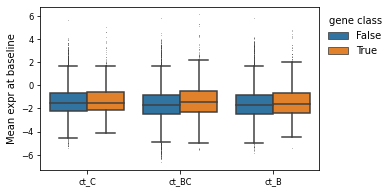

In [119]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='de', data=m_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,1), frameon=False, title='gene class'); 
plt.ylabel('Mean expr at baseline'); plt.xlabel(None)
# plt.ylim(-3.5,4)

(-3.5, 4.0)

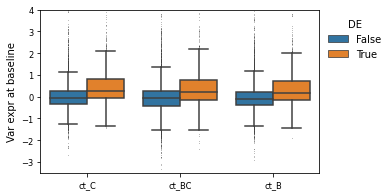

In [120]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='de', data=v_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,1), frameon=False, title='DE'); 
plt.ylabel('Var expr at baseline'); plt.xlabel(None)
plt.ylim(-3.5,4)

Text(0.5, 0, '')

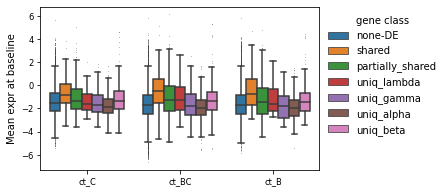

In [121]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='class',data=m_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,1), frameon=False, title='gene class'); 
plt.ylabel('Mean expr at baseline'); plt.xlabel(None)
# plt.ylim(-3.5,4)

(-3.5, 4.0)

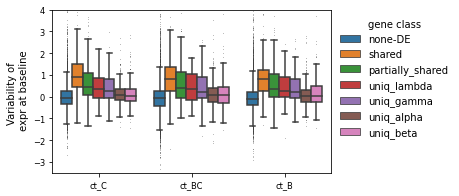

In [122]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='class',data=v_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,1), frameon=False, title='gene class'); 
plt.ylabel('Variability of \n expr at baseline'); plt.xlabel(None)
plt.ylim(-3.5,4)

### Heatmap for correlations at baseline

In [123]:
memento.compute_2d_moments(ctrl, gene_pairs=list(itertools.combinations(included_de_genes,2)))
c_df = memento.get_2d_moments(ctrl, groupby='ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


In [124]:
ct_c_df = c_df[['gene_1', 'gene_2', 'ct_C']]
ct_heatmap = pd.DataFrame(np.zeros((len(included_de_genes), len(included_de_genes))), columns=included_de_genes, index=included_de_genes)
for idx, row in ct_c_df.iterrows():
    
    ct_heatmap.loc[row['gene_1'], row['gene_2']] = row['ct_C']
    ct_heatmap.loc[row['gene_2'], row['gene_1']] = row['ct_C']

(1083, 1083)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

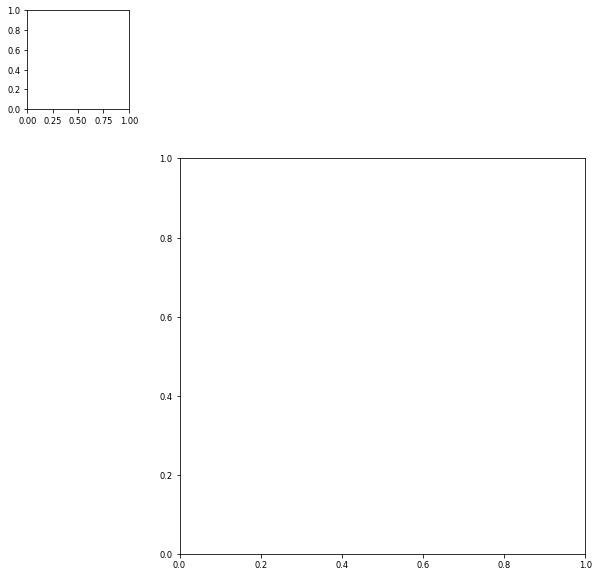

In [125]:
print(ct_heatmap.shape)
cg = sns.clustermap(ct_heatmap, center=0, vmax=0.3); plt.close()
row_inds = cg.dendrogram_row.reordered_ind
col_inds = cg.dendrogram_col.reordered_ind
print(ct_heatmap.shape)


In [ ]:
def classify_color(x):
    
    if x in shared_de_genes:
        return -1
    for idx, stim in enumerate(stims):
        if x in uniq_de_genes[stim]:
            return idx
    return 'impossible'

In [ ]:
class_list = np.array([classify(g) for g in included_de_genes])[:, np.newaxis]

In [ ]:
from matplotlib.colors import LinearSegmentedColormap


myColors = sns.color_palette('husl')[:4]
class_list = np.array([classify_color(g) for g in included_de_genes])[np.newaxis, :]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

In [ ]:
fig = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid((21,20), (2,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((21,20), (0,0), colspan=19, rowspan=2)

sns.heatmap(ct_heatmap.iloc[row_inds, col_inds], cmap='viridis', vmax=0.5, vmin=0.1, ax=ax1, yticklabels=False, xticklabels=False, )
sns.heatmap(class_list[:, row_inds], cmap=cmap, ax=ax2, yticklabels=False, xticklabels=False,)
colorbar = ax2.collections[0].colorbar
colorbar.set_ticks([-0.5, 0.5, 1, 1.5])
colorbar.set_ticklabels(['shared', 'gamma', 'lambda', 'alpha/beta'])

In [ ]:
def draw_lines(x1, x2):
    
    plt.plot([x1, x1], [0, len(col_inds)], color='green', lw=2)
    plt.plot([0, len(col_inds)], [x1, x1], color='green', lw=2)

    plt.plot([x2, x2], [0, len(col_inds)], color='red', lw=2)
    plt.plot([0, len(col_inds)], [x2, x2], color='red', lw=2)

In [ ]:
plt.figure(figsize=(12,10))
# sns.heatmap(ct_heatmap.iloc[row_inds, col_inds], center=0, vmax=0.3)
sns.heatmap(ct_heatmap.loc[filtered_de_genes, filtered_de_genes], cmap='viridis', vmax=0.5, vmin=0.1)

draw_lines(1, len([g for g in shared_de_genes if g in filtered_de_genes]))

x = len([g for g in shared_de_genes if g in filtered_de_genes])
draw_lines(x+1, 
           x+len([g for g in uniq_de_genes['gamma'] if g in filtered_de_genes])
          )

x = x+len([g for g in uniq_de_genes['gamma'] if g in filtered_de_genes])
draw_lines(x+1, 
           x+len([g for g in uniq_de_genes['lambda'] if g in filtered_de_genes])
          )

### Find TFs that govern those genes

In [ ]:
def get_top_tfs(gene_list, plot=False):
    tf_ctrl = adata[
        (adata.obs.stim=='control') & adata.obs.ct.isin(['B', 'C', 'BC'])
    ].copy().copy()
    tf_ctrl.obs['group'] = 1
    memento.create_groups(tf_ctrl, label_columns=['ct', 'donor'])
    memento.compute_1d_moments(tf_ctrl, min_perc_group=.3)
    available_tfs = list(set(tf_list) & set(tf_ctrl.var.index))
    available_targets = list(gene_list & set(tf_ctrl.var.index))

    memento.compute_2d_moments(tf_ctrl, gene_pairs=list(itertools.product(available_tfs, available_targets)))
    moment_df = memento.get_2d_moments(tf_ctrl, groupby='ct')
    moment_df['mag_ct_C'] = moment_df['ct_C'].abs()
    top_tfs = moment_df.groupby('gene_1')['ct_C'].mean().sort_values(ascending=False).head(10).index.tolist()
    top_tf_df = moment_df.query('gene_1 in @top_tfs').copy()
    top_tf_df['gene_1'] = pd.Categorical(top_tf_df['gene_1'].values, categories=top_tfs, ordered=True)
    if plot:
        sns.barplot(x='gene_1', y='ct_C', data=top_tf_df)
    return moment_df, top_tfs

In [ ]:
shared_df, top_tfs = get_top_tfs(shared_de_genes)
lambda_df, _ = get_top_tfs(uniq_de_genes['lambda'])
gamma_df, _ = get_top_tfs(uniq_de_genes['gamma'])
type1_df, _ = get_top_tfs(uniq_de_genes['alpha/beta'])

In [ ]:
shared_df['type'] = 'shared ISGs'
lambda_df['type'] = 'lambda uniq. ISGs'
gamma_df['type'] = 'gamma uniq. ISGs'
type1_df['type'] = 'alpha/beta uniq. ISGs'

In [ ]:
combined_df = pd.concat([shared_df, type1_df, gamma_df, lambda_df])
order = shared_df.groupby('gene_1')['ct_C'].mean().sort_values(ascending=False).head(10).index.tolist()
filtered_df = combined_df.query('gene_1 in @order').copy()
filtered_df['gene_1'] = pd.Categorical(filtered_df['gene_1'].values, categories=order, ordered=True)

In [ ]:
sns.barplot(x='gene_1', y='ct_C', data=filtered_df, hue='type', errwidth=0)
plt.ylabel('Correlation at baseline'); plt.xlabel(None); plt.legend(frameon=False)
plt.title('Top correlated TFs for shared ISGs')
plt.ylim(0, 0.35)

In [ ]:
tf_ctrl = adata[
    (adata.obs.stim=='control') & adata.obs.ct.isin(['B', 'C', 'BC'])
].copy().copy()
tf_ctrl.obs['group'] = 1
memento.create_groups(tf_ctrl, label_columns=['ct', 'donor'])
memento.compute_1d_moments(tf_ctrl, min_perc_group=.3)
available_tfs = list(set(tf_list) & set(tf_ctrl.var.index))
available_targets = list(shared_de_genes & set(tf_ctrl.var.index))

memento.compute_2d_moments(tf_ctrl, gene_pairs=list(itertools.product(available_tfs, available_targets)))


In [ ]:
moment_df = memento.get_2d_moments(tf_ctrl, groupby='ct')
moment_df['mag_ct_C'] = moment_df['ct_C'].abs()

In [ ]:
top_tfs = moment_df.groupby('gene_1')['ct_C'].mean().sort_values(ascending=False).head(10).index.tolist()

In [ ]:
top_tf_df = moment_df.query('gene_1 in @top_tfs').copy()
top_tf_df['gene_1'] = pd.Categorical(top_tf_df['gene_1'].values, categories=top_tfs, ordered=True)

In [ ]:
sns.barplot(x='gene_1', y='ct_C', data=top_tf_df)

In [371]:
stims = ['alpha', 'beta', 'gamma', 'lambda']
ct = 'ciliated'
de_genes = {}
for stim in stims:
    de_genes[stim] = all_result[ct]['ht'][stim]['6'].query('de_fdr < 0.1 & de_coef > 0.5').gene.tolist()
de_genes['alpha/beta'] = set(de_genes['alpha']) | set(de_genes['beta'])

### STAT1 binding site enrichment

In [103]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [104]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [119]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [120]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

In [121]:
# Having a binding site makes you more variable at baseline
v_df['tss_binding'] = v_df['gene'].isin(isgf3_genes)
v_df['deg_type'] = v_df['class'].astype(str).apply(lambda x: {
    'uniq_gamma':'uniq\ntype II', 'uniq_alpha/beta':'uniq\ntype I', 'uniq_lambda':'uniq\ntype III', 'partially_shared':'partial', 'shared':'shared', 'none-DE':'non-DE'}[x])

Text(0, 0.5, 'Proportion with ISGF3 \nbinding site in TSS')

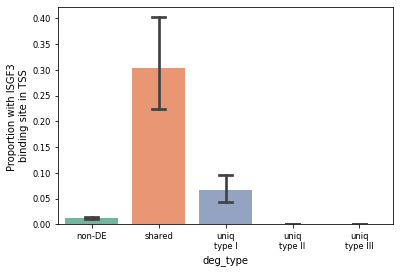

In [122]:
sns.barplot(x='deg_type', y='tss_binding', data=v_df[v_df['deg_type']!='partial'].sort_values('deg_type'), capsize=0.2, palette='Set2');
plt.ylabel('Proportion with ISGF3 \nbinding site in TSS')
# plt.xticks([0, 1, 2, 3, 4], ['none\nDE', 'shared','type III', 'type II', 'type I']);

In [123]:
v_df.head(2)

,gene,ct_C,ct_BC,ct_B,de,class,tss_binding,deg_type
0,LINC01409,0.096451,0.448388,0.107916,False,none-DE,False,non-DE
1,FAM41C,-0.157768,-0.038260,-0.144266,False,none-DE,False,non-DE


In [124]:
stats.mannwhitneyu(v_df.query('tss_binding').ct_C, v_df.query('~tss_binding').ct_C)

MannwhitneyuResult(statistic=1023299.0, pvalue=5.8263460482996915e-05)

(-2.0, 2.0)

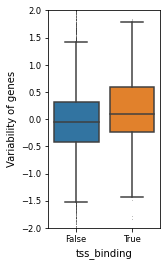

In [125]:
plt.figure(figsize=(2,4))
sns.boxplot(x='tss_binding', y='ct_BC', data=v_df, fliersize=0.1); plt.ylabel('Variability of genes')
plt.ylim(-2, 2)